In [1]:
%load_ext autoreload
%autoreload 2
import pandas
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import twitter as tw

In [2]:
users = {
    'EricPiolle': 'Grenoble en Commun',
#    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
#    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
#    'FranoisTARANTIN': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
#    'GrenobleNvAir': 'Grenoble Nouvel Air',
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',    
}

In [3]:
filename = 'data.csv'
if not os.path.isfile(filename):
    df = pandas.concat([tw.get_data(user, n=200, tag=tag) for user, tag in users.items()])
    df.to_csv(filename, index=False)
else:
    df = pandas.read_csv(filename)
    df['date'] = pandas.to_datetime(df['date'])
print(len(df), len(df.columns))

683 11


In [4]:
df.sample(n=5)

,name,login,likes,retweets,text,date,in_reply,source,coordinates,geo,tag
98,Éric Piolle,EricPiolle,63,39,📺🔴 Je serai l'invité politique de Laurent Ruqu...,2019-10-18 16:27:12,NaN,Twitter for Android,NaN,NaN,Grenoble en Commun
69,Éric Piolle,EricPiolle,42,10,"Après Toulouse cet été, et avant Grenoble, mat...",2019-11-16 14:40:14,NaN,Twitter for Android,NaN,NaN,Grenoble en Commun
294,Emilie CHALAS,EmilieCChalas,1,1,@FCGrugby / @OyonnaxRugby \nC’est parti !! Go ...,2019-12-19 20:00:45,FCGrugby,Twitter for iPhone,NaN,NaN,Un Nouveau Regard sur Grenoble
312,Emilie CHALAS,EmilieCChalas,12,6,#CMGrenoble \n↘️ des financements de la lectur...,2019-12-16 15:09:53,NaN,Twitter for iPhone,NaN,NaN,Un Nouveau Regard sur Grenoble
17,Éric Piolle,EricPiolle,42,23,"🌳🏔️ #GrandAlpe 2030 : avec la Métropole, 650 m...",2020-02-04 16:22:39,NaN,Twitter for Android,NaN,NaN,Grenoble en Commun


In [5]:
df.groupby('name')[['date']].agg(['min', 'count'])

date      
                                   min count
name                                        
Alain Carignon     2019-07-02 09:29:26   200
Emilie CHALAS      2019-11-11 23:07:30   200
Olivier Noblecourt 2019-09-13 07:52:23    83
Éric Piolle        2019-07-09 10:54:35   200

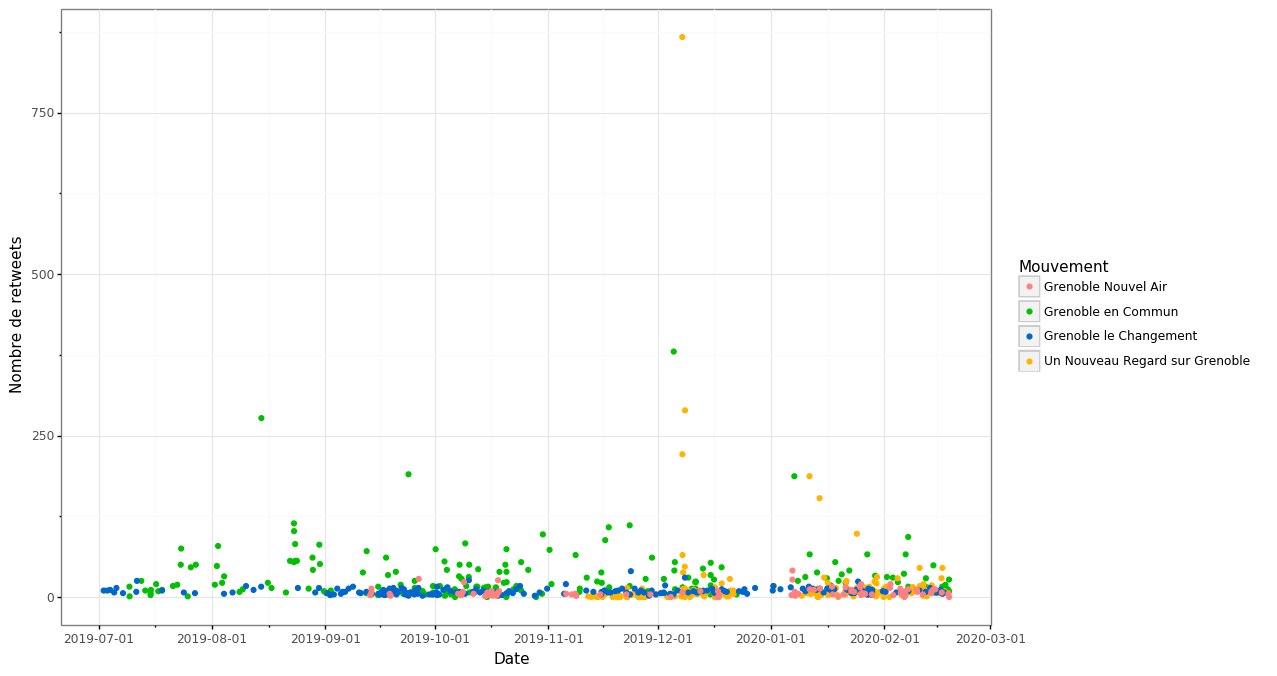

<ggplot: (8781404598280)>

In [6]:
ggplot(df) +\
    aes(x='date', y='retweets', color='tag') +\
    geom_point() +\
    theme_bw() +\
    scale_color_manual(colors) +\
    xlab('Date') +\
    ylab('Nombre de retweets') +\
    labs(color='Mouvement')

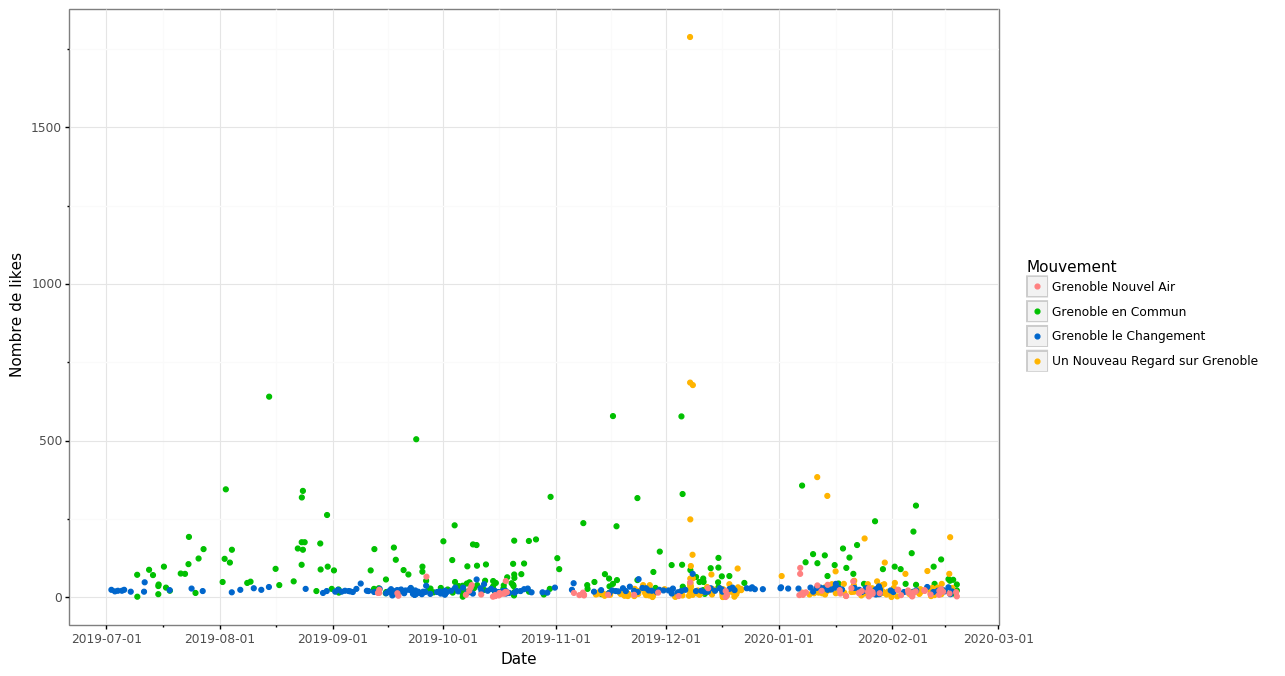

<ggplot: (-9223363255528499989)>

In [7]:
ggplot(df) +\
    aes(x='date', y='likes', color='tag') +\
    geom_point() +\
    theme_bw() +\
    scale_color_manual(colors) +\
    xlab('Date') +\
    ylab('Nombre de likes') +\
    labs(color='Mouvement')

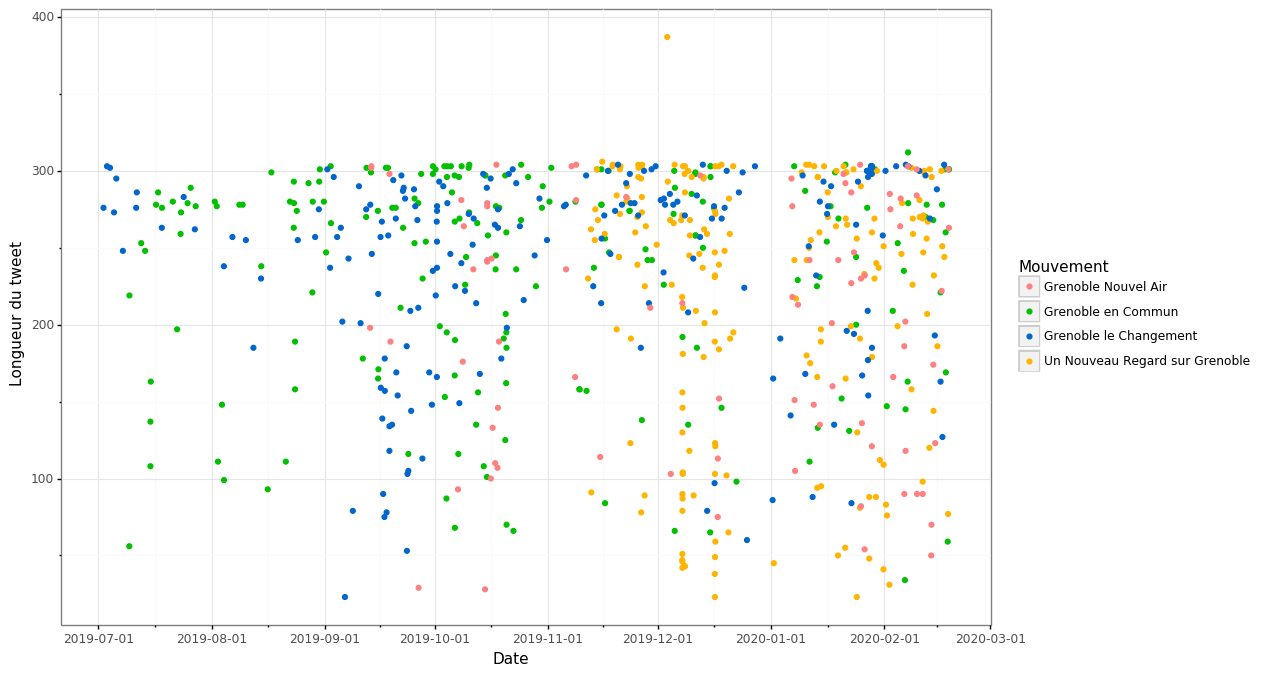

<ggplot: (8781326279695)>

In [8]:
df['text_len'] = df['text'].str.len()
ggplot(df) +\
    aes(x='date', y='text_len', color='tag') +\
    geom_point() +\
    theme_bw() +\
    scale_color_manual(colors) +\
    xlab('Date') +\
    ylab('Longueur du tweet') +\
    labs(color='Mouvement')

In [9]:
df.groupby(['name', 'source'])[['date']].count()

date
name               source                   
Alain Carignon     TweetDeck               6
                   Twitter Web App        30
                   Twitter Web Client      3
                   Twitter for iPhone    161
Emilie CHALAS      Twitter Web App         6
                   Twitter for iPhone    194
Olivier Noblecourt Twitter Web App         4
                   Twitter Web Client      5
                   Twitter for Android    11
                   Twitter for Mac         3
                   Twitter for iPad       15
                   Twitter for iPhone     45
Éric Piolle        Twitter Web App        86
                   Twitter for Android   108
                   Twitter for iPhone      6

In [10]:
tmp = tw.get_mentions(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name               mention               
Olivier Noblecourt @GrenobleNvAir      21
Alain Carignon     @EricPiolle         20
                   @teleGrenoble       14
Emilie CHALAS      @EricPiolle         13
Alain Carignon     @JJBourdin_RMC      11
                   @ledauphine          8
Emilie CHALAS      @MarleneSchiappa     7
                   @AssembleeNat        7
                   @barbarapompili      7
Éric Piolle        @editionsLLL         6
                   @FestivalDuLivre     6
Emilie CHALAS      @onoblecourt         5
Éric Piolle        @Francois_Ruffin     5
Olivier Noblecourt @agnesbuzyn          5
                   @Delegpauvrete       5
Emilie CHALAS      @gouvernementFR      5
Olivier Noblecourt @duboschristelle     5
Alain Carignon     @RMCinfo             5
Emilie CHALAS      @m_chamussy          4
Alain Carignon     @FCGrugby_en         4

In [11]:
tmp = tw.get_hashtags(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name               mention                            
Alain Carignon     #Grenoble                       139
                   #Carignon2020                    95
Emilie CHALAS      #Grenoble                        65
Alain Carignon     #SocieteCivile                   49
Olivier Noblecourt #Grenoble                        18
                   #Strat                           18
Emilie CHALAS      #Municipales2020                 13
                   #UnNouveauRegardSurGrenoble      13
Alain Carignon     #SocieteCivilePourlAlternance    11
                   #grenoble                         9
Emilie CHALAS      #TransitionEcologique             9
                   #CMGrenoble                       8
                   #grenoble                         7
                   #ParoleDeFemme                    6
Alain Carignon     #IncendieMairieGrenoble           6
Emilie CHALAS      #VilleNature                      6
Éric Piolle        #CETA                             6
Olivier Noblecourt #GrenobleNouvelAir                5
Emilie CHALAS      #GrenelleViolencesConjugales      5
Alain Carignon     #BourdinDirect                    5

In [12]:
tmp = tw.get_pattern(df, 'climat')
tmp.groupby(['name'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

,date
name,
Éric Piolle,47
Olivier Noblecourt,4
Alain Carignon,2


In [13]:
tmp = tw.get_pattern(df, 'piolle')
tmp.groupby(['name'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

,date
name,
Alain Carignon,24
Emilie CHALAS,14
Olivier Noblecourt,5


In [14]:
tmp = tw.get_pattern(df, 'chalas')
tmp.groupby(['name'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

,date
name,
Olivier Noblecourt,2
Emilie CHALAS,1


In [15]:
tmp = tw.get_pattern(df, 'carignon')
tmp.groupby(['name'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

,date
name,
Alain Carignon,96
Emilie CHALAS,4
Olivier Noblecourt,1


In [16]:
tmp = tw.get_pattern(df, 'noblecourt')
tmp.groupby(['name'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

,date
name,
Emilie CHALAS,5
Olivier Noblecourt,5


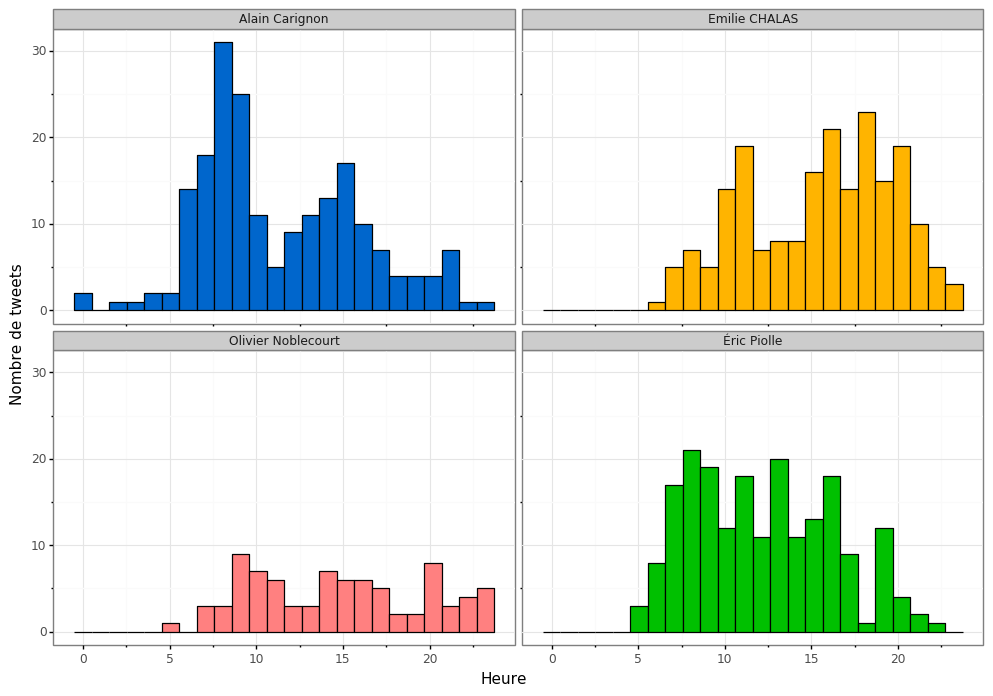

<ggplot: (8781326408915)>

In [17]:
df['time'] = pandas.to_timedelta(df['date'].dt.time.astype(str)).dt.total_seconds() / 3600  # some dirty hack
ggplot(df) +\
    aes(x='time', fill='tag') +\
    geom_histogram(color='black', bins=24) +\
    theme_bw() +\
    scale_fill_manual(colors) +\
    xlab('Heure') +\
    ylab('Nombre de tweets') +\
    labs(fill='Mouvement') +\
    facet_wrap('name') +\
    theme(legend_position='none')